# Preparation

In [1]:
import os

import numpy as np
import pandas as pd
pd.options.display.max_columns = 500
pd.options.plotting.backend = 'matplotlib'

import umap
# import umap.plot
# import plotly.io as pio
# import plotly.express as px
# pio.templates.default = "plotly_white" # "plotly", "plotly_white", "plotly_dark", "ggplot2", "seaborn", "simple_white", "none"

import seaborn as sns
sns.set_style("whitegrid")

import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True

%matplotlib inline

# Data Schema

In [2]:
df = pd.read_csv(
        "data/NOTEEVENTS.csv",
  #     na_values=[ '', ' ', '?', '?|?','None', '-NaN', '-nan', '', 'N/A', 'NA', 'NULL', 'NaN', 'n/a', 'nan', 'null']
) #.fillna(np.nan)

# shuffle the DataFrame rows
df = df.sample(frac = 1)

/Users/admin/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
724369,729222,96429,139449.0,2181-04-24,2181-04-24 11:17:00,2181-04-24 11:28:10,Nursing,Nursing Transfer Note,15858.0,NaN,"72 y/o female with PMH of DM, AS, AF ([**3-/2..."
1714648,1712381,2465,181316.0,2172-03-03,2172-03-03 03:18:00,2172-03-03 03:20:00,Nursing/other,Report,20731.0,NaN,RESPIRATORY CARE NOTE\nBaby [**Known lastname ...
1956232,1930200,18011,171489.0,2152-05-10,2152-05-10 19:49:00,2152-05-10 19:57:00,Nursing/other,Report,15157.0,NaN,NPN\nAddendum:\nInfant noted at 1700 to have s...
1913433,1914225,16665,165174.0,2166-06-18,2166-06-18 03:24:00,2166-06-18 03:33:00,Nursing/other,Report,14424.0,NaN,NICU Attending Triage Note\n\nAsked to evaluat...
493641,491711,42842,162017.0,2199-10-16,2199-10-16 11:51:00,2199-10-16 11:51:15,Rehab Services,Bedside Swallowing Evaluation,15731.0,NaN,TITLE: BEDSIDE SWALLOWING EVALUATION:\nHISTOR...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2083180 entries, 724369 to 788250
Data columns (total 11 columns):
 #   Column       Dtype  
---  ------       -----  
 0   ROW_ID       int64  
 1   SUBJECT_ID   int64  
 2   HADM_ID      float64
 3   CHARTDATE    object 
 4   CHARTTIME    object 
 5   STORETIME    object 
 6   CATEGORY     object 
 7   DESCRIPTION  object 
 8   CGID         float64
 9   ISERROR      float64
 10  TEXT         object 
dtypes: float64(3), int64(2), object(6)
memory usage: 190.7+ MB


# Data Embeddings

In [5]:
df.TEXT

724369     72 y/o female with PMH of  DM, AS, AF ([**3-/2...
1714648    RESPIRATORY CARE NOTE\nBaby [**Known lastname ...
1956232    NPN\nAddendum:\nInfant noted at 1700 to have s...
1913433    NICU Attending Triage Note\n\nAsked to evaluat...
493641     TITLE:  BEDSIDE SWALLOWING EVALUATION:\nHISTOR...
                                 ...                        
1468544    ADENDDUM TO NOTES ABOVE\n\nSTART NITRO GTT AT ...
1671450    NPN 7pm-7am\n\n\nRESP: Received infant on IMV ...
865536     [**2183-3-20**] 5:26 PM\n CHEST (PORTABLE AP) ...
684521     SICU\n   HPI:\n   59 yo f w/ gerd, underwent l...
788250     [**2157-4-21**] 10:53 AM\n BILAT DIAGNOSTIC MA...
Name: TEXT, Length: 2083180, dtype: object

In [6]:
# !pip install 'lightning-flash[text]'
# !pip install --ignore-installed Pillow==9.0.0
# !pip install opencv-python
# !!pip install "opencv-python-headless<4.3"
import flash
from flash.text import TextClassificationData, TextEmbedder

# Wrapping the prediction data inside a datamodule
datamodule = TextClassificationData.from_lists(
    predict_data=df["TEXT"].to_list()[:10000],
    batch_size=10,
)

# We are loading a pre-trained SentenceEmbedder
model = TextEmbedder(backbone="sentence-transformers/all-MiniLM-L6-v2")

/Users/admin/opt/anaconda3/lib/python3.8/site-packages/pl_bolts/models/self_supervised/amdim/__init__.py:1: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  from pl_bolts.models.self_supervised.amdim.amdim_module import AMDIM
/Users/admin/opt/anaconda3/lib/python3.8/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:65: UnderReviewWarning: The feature FeatureMapContrastiveTask is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  class AMDIM(LightningModule):
/

In [7]:
trainer = flash.Trainer(gpus=0)

#Since this task is tackled unsupervised, the predict method generates sentence embeddings using the prediction input
embeddings = trainer.predict(model, datamodule=datamodule)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Predicting: 0it [00:00, ?it/s]

In [8]:
import itertools
flatten_embeddings = np.array([item.numpy() for sublist in embeddings for item in sublist])

reduced_embeddings = umap.UMAP(
    n_components=2, 
    min_dist=0.3, 
    metric='correlation', 
    random_state=42, 
    verbose=True
).fit_transform(flatten_embeddings)


UMAP(angular_rp_forest=True, metric='correlation', min_dist=0.3, random_state=42, verbose=True)
Mon Jan  9 15:28:05 2023 Construct fuzzy simplicial set
Mon Jan  9 15:28:05 2023 Finding Nearest Neighbors
Mon Jan  9 15:28:05 2023 Building RP forest with 10 trees
Mon Jan  9 15:28:05 2023 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	 4  /  13
	 5  /  13
	Stopping threshold met -- exiting after 5 iterations
Mon Jan  9 15:28:20 2023 Finished Nearest Neighbor Search
Mon Jan  9 15:28:23 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Mon Jan  9 15:28:43 2023 Finished embedding


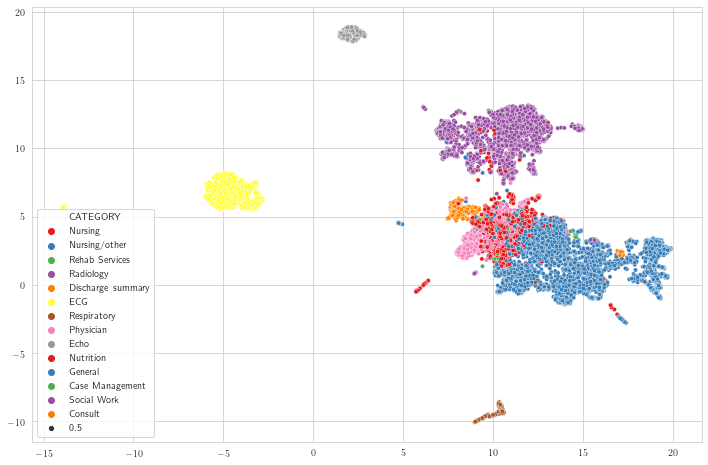

In [10]:
fig = plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=reduced_embeddings[:, 0], 
    y=reduced_embeddings[:, 1], 
    palette="Set1", #"PiYG", #"Spectral", 
    size=0.5,
    hue=df["CATEGORY"][:10000]
)
plt.show()